In [6]:
!pip install torch
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.2 MB/s eta 0:00:00


In [2]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

class TechnicalIndicators:
    def __init__(self, data):
        self.data = data

    def add_momentum_indicators(self):
        self.data['RSI'] = self.calculate_rsi(self.data['Close'], 14)
        self.data['MACD'], self.data['MACD_signal'], self.data['MACD_hist'] = self.calculate_macd(self.data['Close'], 12, 26, 9)
        self.data['Stoch_k'], self.data['Stoch_d'] = self.calculate_stoch(self.data['High'], self.data['Low'], self.data['Close'], 14, 3, 3)

    def add_volume_indicators(self):
        self.data['OBV'] = self.calculate_obv(self.data['Close'], self.data['Volume'])

    def add_volatility_indicators(self):
        self.data['Upper_BB'], self.data['Middle_BB'], self.data['Lower_BB'] = self.calculate_bbands(self.data['Close'], 20)
        self.data['ATR_1'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], 1)
        self.data['ATR_2'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], 2)
        self.data['ATR_5'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], 5)
        self.data['ATR_10'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], 10)
        self.data['ATR_20'] = self.calculate_atr(self.data['High'], self.data['Low'], self.data['Close'], 20)

    def add_trend_indicators(self):
        self.data['ADX'] = self.calculate_adx(self.data['High'], self.data['Low'], self.data['Close'], 14)
        self.data['+DI'] = self.calculate_plus_di(self.data['High'], self.data['Low'], self.data['Close'], 14)
        self.data['-DI'] = self.calculate_minus_di(self.data['High'], self.data['Low'], self.data['Close'], 14)
        self.data['CCI'] = self.calculate_cci(self.data['High'], self.data['Low'], self.data['Close'], 5)

    def add_other_indicators(self):
        self.data['DLR'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.data['TWAP'] = self.data['Close'].expanding().mean()
        self.data['VWAP'] = (self.data['Volume'] * (self.data['High'] + self.data['Low']) / 2).cumsum() / self.data['Volume'].cumsum()

    def add_all_indicators(self):
        self.add_momentum_indicators()
        self.add_volume_indicators()
        self.add_volatility_indicators()
        self.add_trend_indicators()
        self.add_other_indicators()
        return self.data

    @staticmethod
    def calculate_rsi(series, period):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    @staticmethod
    def calculate_macd(series, fastperiod, slowperiod, signalperiod):
        fast_ema = series.ewm(span=fastperiod, min_periods=fastperiod).mean()
        slow_ema = series.ewm(span=slowperiod, min_periods=slowperiod).mean()
        macd = fast_ema - slow_ema
        signal = macd.ewm(span=signalperiod, min_periods=signalperiod).mean()
        hist = macd - signal
        return macd, signal, hist

    @staticmethod
    def calculate_stoch(high, low, close, fastk_period, slowk_period, slowd_period):
        lowest_low = low.rolling(window=fastk_period).min()
        highest_high = high.rolling(window=fastk_period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=slowd_period).mean()
        return k, d

    @staticmethod
    def calculate_obv(close, volume):
        obv = volume * ((close.diff() > 0).astype(int) - (close.diff() < 0).astype(int)).cumsum()
        return obv

    @staticmethod
    def calculate_bbands(series, period):
        sma = series.rolling(window=period).mean()
        std = series.rolling(window=period).std()
        upper = sma + (std * 2)
        middle = sma
        lower = sma - (std * 2)
        return upper, middle, lower

    @staticmethod
    def calculate_atr(high, low, close, period):
        tr = pd.DataFrame({
            'tr1': high - low,
            'tr2': abs(high - close.shift(1)),
            'tr3': abs(low - close.shift(1))
        }).max(axis=1)
        atr = tr.rolling(window=period).mean()
        return atr

    @staticmethod
    def calculate_adx(high, low, close, period):
        plus_dm = high.diff().clip(lower=0)
        minus_dm = -low.diff().clip(upper=0)
        tr = pd.DataFrame({
            'tr1': high - low,
            'tr2': abs(high - close.shift(1)),
            'tr3': abs(low - close.shift(1))
        }).max(axis=1)
        atr = tr.rolling(window=period).mean()

        plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
        minus_di = 100 * (minus_dm.ewm(alpha=1/period).mean() / atr)

        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di)).ewm(alpha=1/period).mean()
        return dx

    @staticmethod
    def calculate_plus_di(high, low, close, period):
        plus_dm = high.diff().clip(lower=0)
        tr = pd.DataFrame({
            'tr1': high - low,
            'tr2': abs(high - close.shift(1)),
            'tr3': abs(low - close.shift(1))
        }).max(axis=1)
        atr = tr.rolling(window=period).mean()
        plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / atr)
        return plus_di

    @staticmethod
    def calculate_minus_di(high, low, close, period):
        minus_dm = -low.diff().clip(upper=0)
        tr = pd.DataFrame({
            'tr1': high - low,
            'tr2': abs(high - close.shift(1)),
            'tr3': abs(low - close.shift(1))
        }).max(axis=1)
        atr = tr.rolling(window=period).mean()
        minus_di = 100 * (minus_dm.ewm(alpha=1/period).mean() / atr)
        return minus_di

    @staticmethod
    def calculate_cci(high, low, close, period):
        tp = (high + low + close) / 3
        sma = tp.rolling(window=period).mean()
        mad = tp.rolling(window=period).apply(lambda x: np.fabs(x - x.mean()).mean())
        cci = (tp - sma) / (0.015 * mad)
        return cci


class TradeDataset(Dataset):
    def __init__(self, data, sequence_length=60):
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length, :-1]
        y = self.data[idx + self.sequence_length - 1, -1]
        return x, y.long()


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 3)  # For Buy, Sell, Hold

    def forward(self, src, src_mask=None):
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output[:, -1, :])  # Take the last time step
        return output


def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    
    # Preprocessing to create necessary columns
    data['price'] = data['price'] / 1e9
    data['bid_px_00'] = data['bid_px_00'] / 1e9
    data['ask_px_00'] = data['ask_px_00'] / 1e9

    data['Close'] = data['price']
    data['Volume'] = data['size']
    data['High'] = data[['bid_px_00', 'ask_px_00']].max(axis=1)
    data['Low'] = data[['bid_px_00', 'ask_px_00']].min(axis=1)
    data['Open'] = data['Close'].shift(1).fillna(data['Close'])

    ti = TechnicalIndicators(data)
    df_with_indicators = ti.add_all_indicators()
    
    # Drop any non-numeric columns
    df_with_indicators = df_with_indicators.select_dtypes(include=[np.number])
    
    # Fill NaN values with 0 (or another appropriate method)
    df_with_indicators = df_with_indicators.fillna(0)
    
    # Normalize the data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(df_with_indicators)
    
    # Create a target: 2 if price goes up, 0 if it goes down, 1 if it stays the same
    target = np.diff(df_with_indicators['Close'], prepend=df_with_indicators['Close'][0])
    target = np.where(target > 0, 2, np.where(target < 0, 0, 1))
    
    # Combine features and target
    final_data = np.column_stack((normalized_data, target))
    
    return final_data


def train_with_scheduler(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, early_stopping_patience=5):
    device = next(model.parameters()).device
    best_loss = float('inf')
    patience = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
        scheduler.step(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print('Early stopping')
                break


def main():
    # Load and preprocess data
    file_path = '/teamspace/uploads/xnas-itch-20230703.tbbo.csv'
    preprocessed_data = preprocess_data(file_path)

    # Prepare data for model
    sequence_length = 60
    dataset = TradeDataset(preprocessed_data, sequence_length=sequence_length)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model and training components
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerModel(input_dim=preprocessed_data.shape[1] - 1, d_model=64, nhead=4, num_layers=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Train the model
    train_with_scheduler(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, early_stopping_patience=5)


if __name__ == "__main__":
    main()


Epoch 1/50, Loss: 0.06615126309136607
Epoch 2/50, Loss: 0.010613503180139879
Epoch 3/50, Loss: 0.006928330532666283
Epoch 4/50, Loss: 0.006123223839969746
Epoch 5/50, Loss: 0.005343116378339097
Epoch 6/50, Loss: 0.004679107681840955
Epoch 7/50, Loss: 0.003626292874986643
Epoch 8/50, Loss: 0.0036984187916988993
Epoch 9/50, Loss: 0.002643247210852961
Epoch 10/50, Loss: 0.0024166800192529803
Epoch 11/50, Loss: 0.0022915866960323563
Epoch 12/50, Loss: 0.0027099986595096664
Epoch 13/50, Loss: 0.0018932242363438494
Epoch 14/50, Loss: 0.0014585776160138874
Epoch 15/50, Loss: 0.0015705158459043177
Epoch 16/50, Loss: 0.0017244295394903326
Epoch 17/50, Loss: 0.0013863330232498682
Epoch 18/50, Loss: 0.0011825920177975214
Epoch 19/50, Loss: 0.0011961455983528987
Epoch 20/50, Loss: 0.0012764730921952685
Epoch 21/50, Loss: 0.0007172319581244896
Epoch 22/50, Loss: 0.0015490398700323536
Epoch 23/50, Loss: 0.0007569479132394453
Epoch 24/50, Loss: 0.0013436492364320525
Epoch 25/50, Loss: 0.0007698322601

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Momentum Strategy Function
def momentum_strategy(data):
    data['pct_change'] = data['Close'].pct_change(periods=5)
    signals = np.where(data['pct_change'] > 0, 2, np.where(data['pct_change'] < 0, 0, 1))
    return signals

# Model Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f'Accuracy of the model on test data: {accuracy * 100:.2f}%')
    return accuracy

# Evaluation against Momentum Strategy
def evaluate_against_strategy(model, data_loader, device, raw_data):
    model.eval()
    correct_model = 0
    correct_strategy = 0
    total = 0
    momentum_signals = momentum_strategy(raw_data)

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Adjust for sequence length
            strategy_signal = momentum_signals[i + 59]  # Ensure alignment with data_loader
            total += targets.size(0)

            correct_model += (predicted == targets).sum().item()
            correct_strategy += (strategy_signal == targets.cpu().numpy()).sum()

    accuracy_model = correct_model / total
    accuracy_strategy = correct_strategy / total
    print(f'Accuracy of the model on test data: {accuracy_model * 100:.2f}%')
    print(f'Accuracy of the momentum strategy on test data: {accuracy_strategy * 100:.2f}%')
    return accuracy_model, accuracy_strategy

# Function to run evaluations after training
def run_evaluations():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    file_path = '/teamspace/uploads/xnas-itch-20230703.tbbo.csv'
    preprocessed_data = preprocess_data(file_path)

    raw_data = pd.read_csv(file_path)
    raw_data['price'] = raw_data['price'] / 1e9
    raw_data['Close'] = raw_data['price']
    raw_data['High'] = raw_data[['bid_px_00', 'ask_px_00']].max(axis=1)
    raw_data['Low'] = raw_data[['bid_px_00', 'ask_px_00']].min(axis=1)
    raw_data['Open'] = raw_data['Close'].shift(1).fillna(raw_data['Close'])

    sequence_length = 60
    dataset = TradeDataset(preprocessed_data, sequence_length=sequence_length)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    _, test_dataset = random_split(dataset, [train_size, test_size])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TransformerModel(input_dim=preprocessed_data.shape[1] - 1, d_model=64, nhead=4, num_layers=2).to(device)
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)

    evaluate_model(model, test_loader, device)
    evaluate_against_strategy(model, test_loader, device, raw_data)

# Run this function separately after training the model
run_evaluations()


Accuracy of the model on test data: 99.97%
Accuracy of the model on test data: 99.97%
Accuracy of the momentum strategy on test data: 22.23%


Accuracy of the model on test data: 99.98%
Precision of the model on test data: 99.95%
Recall of the model on test data: 99.99%
F1 Score of the model on test data: 99.97%


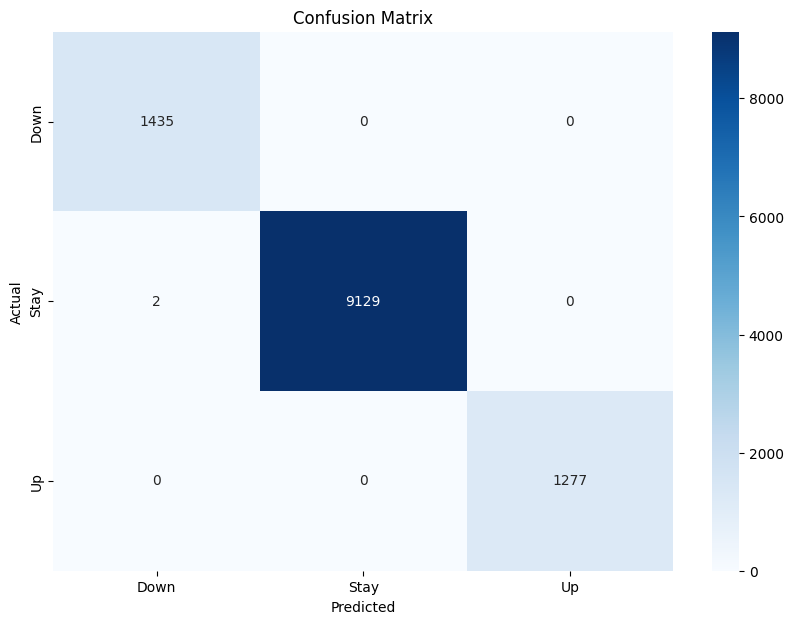

Accuracy of the model on test data: 99.98%
Accuracy of the momentum strategy on test data: 22.60%


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_extended(model, data_loader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    print(f'Accuracy of the model on test data: {accuracy * 100:.2f}%')
    print(f'Precision of the model on test data: {precision * 100:.2f}%')
    print(f'Recall of the model on test data: {recall * 100:.2f}%')
    print(f'F1 Score of the model on test data: {f1 * 100:.2f}%')

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Stay', 'Up'], yticklabels=['Down', 'Stay', 'Up'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def run_evaluations():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    file_path = '/teamspace/uploads/xnas-itch-20230703.tbbo.csv'
    preprocessed_data = preprocess_data(file_path)

    raw_data = pd.read_csv(file_path)
    raw_data['price'] = raw_data['price'] / 1e9
    raw_data['Close'] = raw_data['price']
    raw_data['High'] = raw_data[['bid_px_00', 'ask_px_00']].max(axis=1)
    raw_data['Low'] = raw_data[['bid_px_00', 'ask_px_00']].min(axis=1)
    raw_data['Open'] = raw_data['Close'].shift(1).fillna(raw_data['Close'])

    sequence_length = 60
    dataset = TradeDataset(preprocessed_data, sequence_length=sequence_length)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    _, test_dataset = random_split(dataset, [train_size, test_size])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TransformerModel(input_dim=preprocessed_data.shape[1] - 1, d_model=64, nhead=4, num_layers=2).to(device)
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)

    evaluate_model_extended(model, test_loader, device)
    evaluate_against_strategy(model, test_loader, device, raw_data)

# Run this function separately after training the model
run_evaluations()